# Ciclo 2 - Avaliação

- Reproduz a validação dos classificadores.
- Dá detalhes sobre o dataset, os dados, as features e os classificadores;

A partir da versão estendida do INPI-BR, treina novamente os estimadores escolhidos como Falcon Heavy (SVM) e Falcon 9 (MLP) utilizando a melhor configuração de hiper-parâmetros identificada nas etapas de desenvolvimento e demonstração.

In [2]:
import re
import os
import sys
sys.path.append('../')  # running from `project_root/notebooks`
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid", color_codes=True)

from dataset import clean_df
from machine_learning import ENV, plot_dist, load_obj, word_tokenizer, text_length_hist
from sklearn import metrics

from IPython.core.display import Image, display


kinds = ['strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar']


def ranking(engine='catplot', **kwargs):
    centimeters = 20
    height = centimeters/2.54
    if engine == 'catplot':
        g = sns.catplot(**kwargs, height=height, palette='colorblind');
    elif engine == 'lineplot':
        plt.figure(figsize=(centimeters, centimeters/2));
        g = sns.lineplot(**kwargs, palette='colorblind');
    elif engine == 'lmplot':
        g = sns.lmplot(**kwargs, height=height, palette='colorblind');
    elif engine == 'relplot':
        g = sns.relplot(**kwargs, height=height, palette='colorblind');
    plt.savefig(os.path.join(ENV['CACHE_FOLDER'], f'ranking_{kwargs.get("kind", engine)}_{kwargs["y"]}_by_{kwargs["x"]}+{kwargs["hue"]}_per_{kwargs.get("row", "")}_{kwargs.get("col", "")}{ENV["PLT_EXT"]}'));



RANDOM_STATE = 572
NUM_SAMPLES = 5000
N_GRAMS = 1

TFIDF = 'tfidf_titleabstract_1_0.95_8237_342704'
LSA = 'lsa_1000_titleabstract_1_0.95_8237_342704'
ENC = 'class_encoder_8237_342704'
FALCON_NINE = 'mlp_1000_titleabstract_1_0.95_8237_342704'
FALCON_NINE_cm = 'cm_mlp_1000_titleabstract_1_0.95_8237_342704.png'
FALCON_HEAVY = 'svm_titleabstract_1_0.95_8237_342704'
FALCON_HEAVY_cm = 'cm_svm_titleabstract_1_0.95_8237_342704.png'

work_tokens_object = 'clean_dense_dataset_evaluation_work_titleabstract_tokenized'
val_tokens_object = 'clean_dense_dataset_evaluation_val_titleabstract_tokenized'

## Dataset INPI-BR v5

### Distribuição dos exemplos pela data de classificação

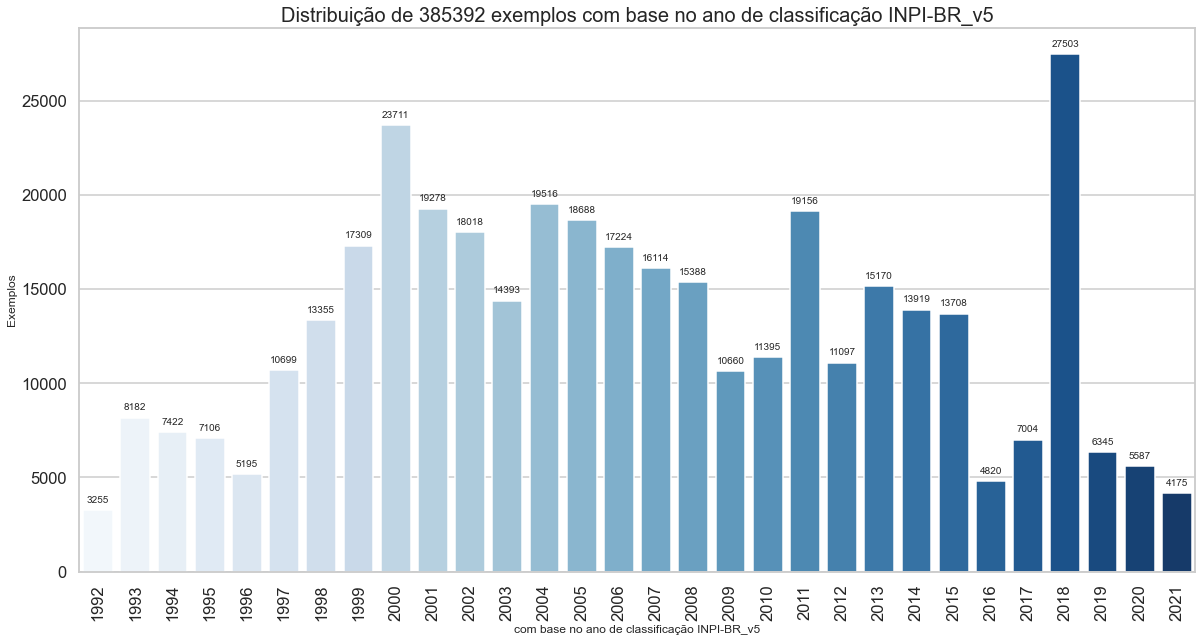

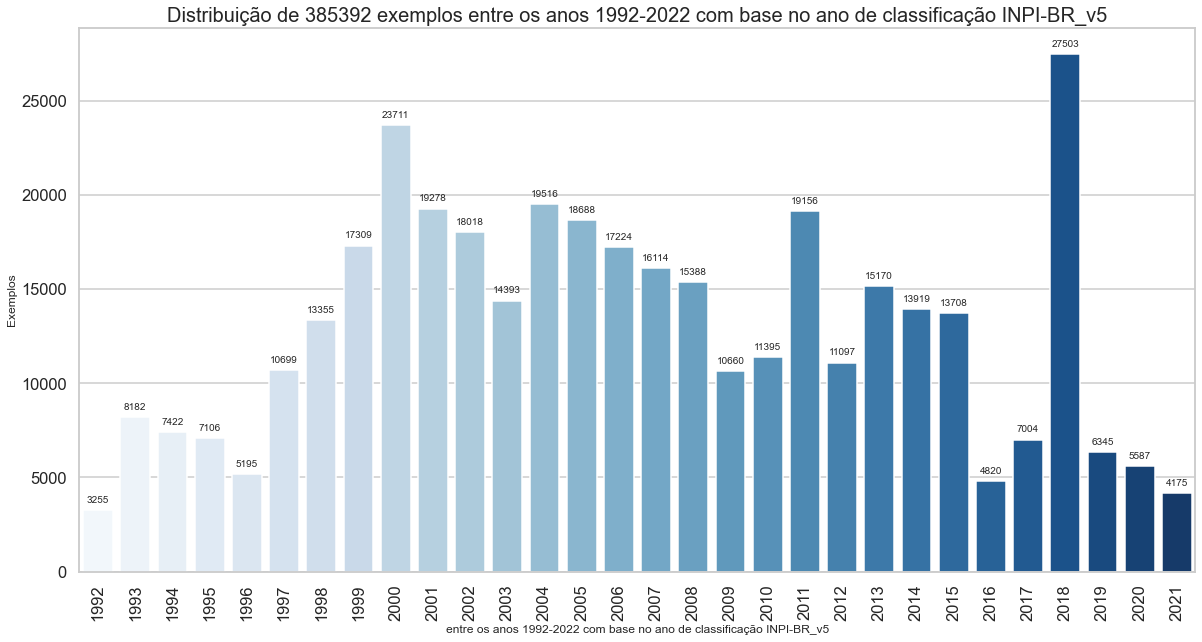

In [6]:
df_plot = df_eva.dropna(subset=['classif_date'])

# complete dataset
plot_dist(df_plot['classif_date'].dt.year, label=f'com base no ano de classificação {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['classif_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de classificação {id_label}', palette='Blues');

### Distribuição dos exemplos pela área de exame

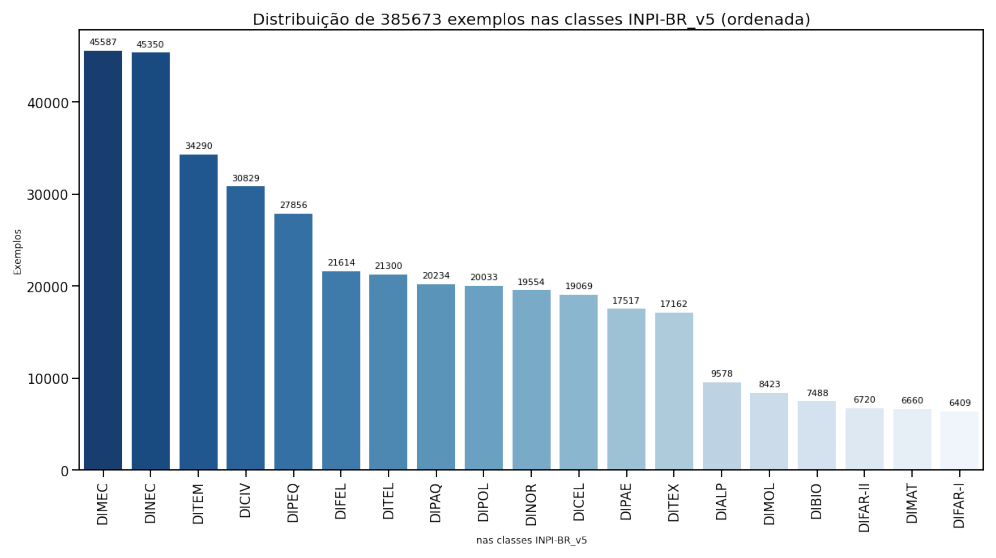

In [7]:
plot_dist(df_eva['area'], label=f'nas classes {id_label}', sort=True, data_points_fontsize=11, palette='Blues_r');


### Distribuição dos exemplos pela data de depósito

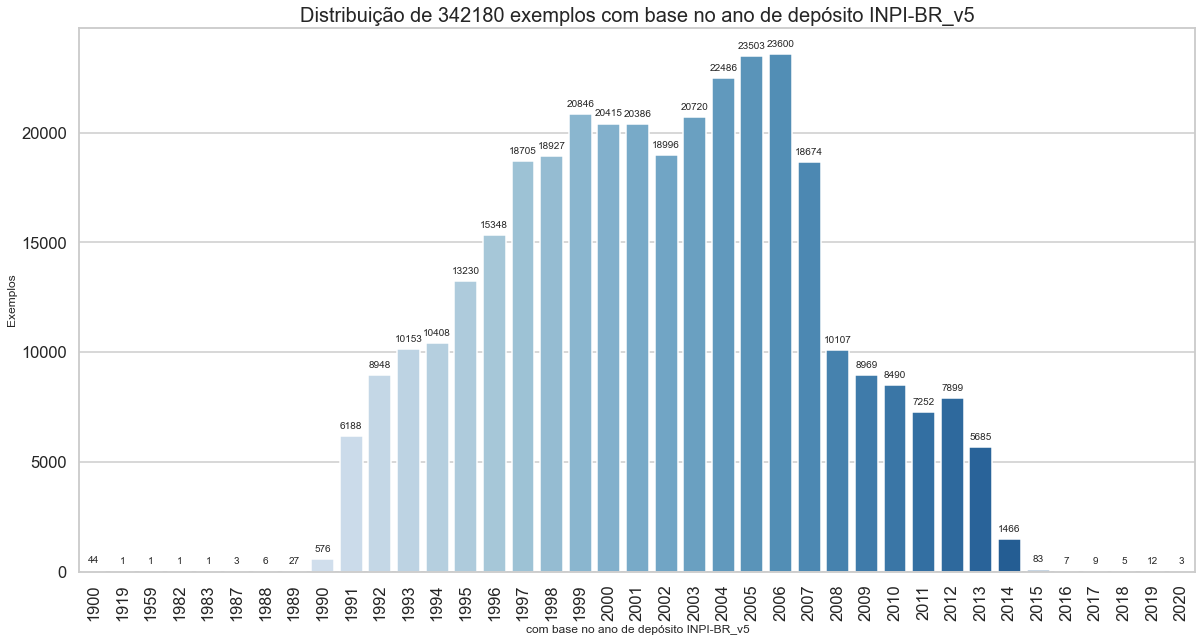

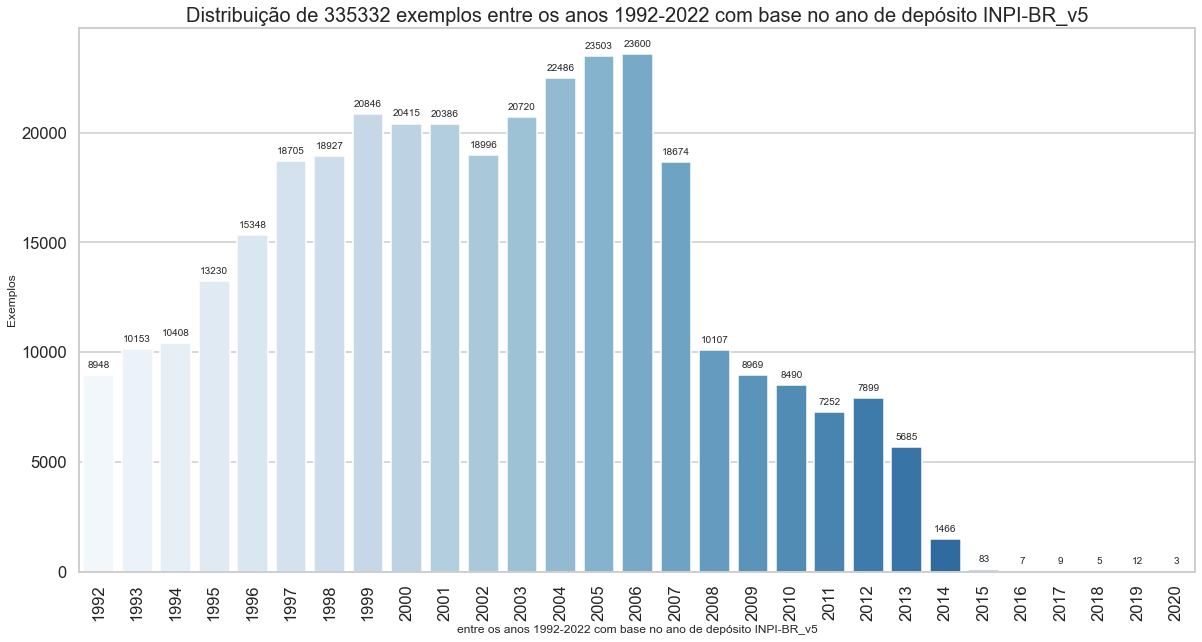

In [8]:
df_plot = df_eva.dropna(subset=['deposit_date'])

# complete dataset
plot_dist(df_plot['deposit_date'].dt.year, label=f'com base no ano de depósito {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['deposit_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de depósito {id_label}', palette='Blues');

## Análise Exploratória de Dados

Dados utilizados no treinamento (dense_dataset_evaluation_work.csv) e na validação (dense_dataset_evaluation_val.csv) da etapa de Avaliação do DSRM.

### Subconjunto de treinamento (_work)

In [10]:
id_label = 'Work subset'

df_work = load_obj(work_tokens_object)
df_work.sample(5, random_state=RANDOM_STATE)

,no_pedido,classif_date,title,abstract,ipc,titleabstract,area,last_rpi,deposit_date,titleabstract_tokens
199123,PI0314373,2018-03-27,PRODUTO IMUNOGÊNICO ESTÁVEL PARA A INDUÇÃO DE ...,PRODUTO IMUNOGÊNICO ESTÁVEL PARA A INDUÇÃO DE ...,"['A61K 39/385', 'A61K 39/00', 'A61K 47/64', 'A...",PRODUTO IMUNOGÊNICO ESTÁVEL PARA A INDUÇÃO DE ...,DIMOL,1802,2003-09-16,produt imunogên est induç anticorp contr vár p...
86625,MU7801342,2000-03-08,TORNO PORTATIL PARA USINAGEM DE CILINDROS,TORNO PORTÁTIL PARA USINAGEM DE CILINDROS A pr...,['B23B 3/02'],TORNO PORTATIL PARA USINAGEM DE CILINDROS TORN...,DIMEC,1522,1998-02-18,torn portatil usin cilindr torn portátil usin ...
27721,PI9500689,1995-10-24,VÁLVULA DE FREIO DE DOIS ESTÁGIOS PARA COMUNIC...,Válvulas de freio de dois estágios esquerda e ...,['F15B 15/14'],VÁLVULA DE FREIO DE DOIS ESTÁGIOS PARA COMUNIC...,DITEM,1299,1995-02-17,válvul frei doi estági comunic press flu mecan...
249739,PI0512857,2008-04-08,SUBSTÂNCIA POLIMÉRICA MÉTODO DE TRATAR UMA SUP...,SUBSTÂNCIA POLIMÉRICA MÉTODO DE TRATAR UMA SUP...,"['C08J 7/12', 'B29C 59/12']",SUBSTÂNCIA POLIMÉRICA MÉTODO DE TRATAR UMA SUP...,DIPOL,1944,2005-04-30,subst polimér métod trat superfíci subst polim...
102374,PI9814818,2000-10-03,MÉTODOS DE TRATAMENTO DE CÁPSULAS E FORMULAÇÕE...,Patente de Invenção MÉTODOS DE TRATAMENTO DE C...,"['A61K 9/48', 'A61K 9/14']",MÉTODOS DE TRATAMENTO DE CÁPSULAS E FORMULAÇÕE...,DIFAR-I,1552,1998-10-05,métod trat cápsul formul farmac pó sec patent ...


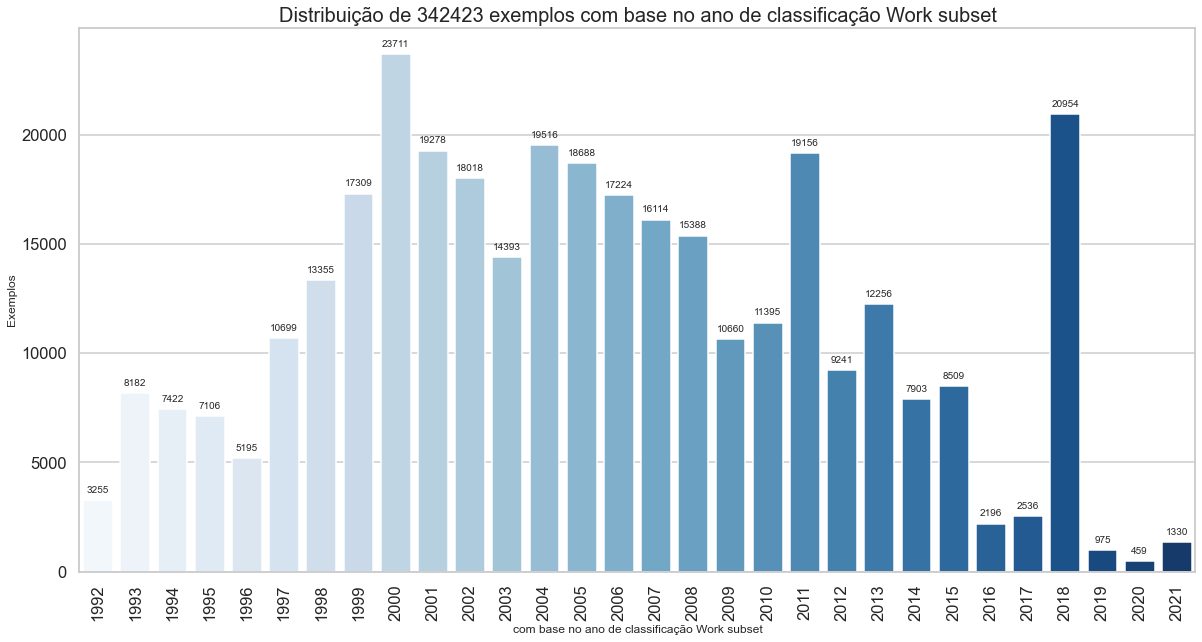

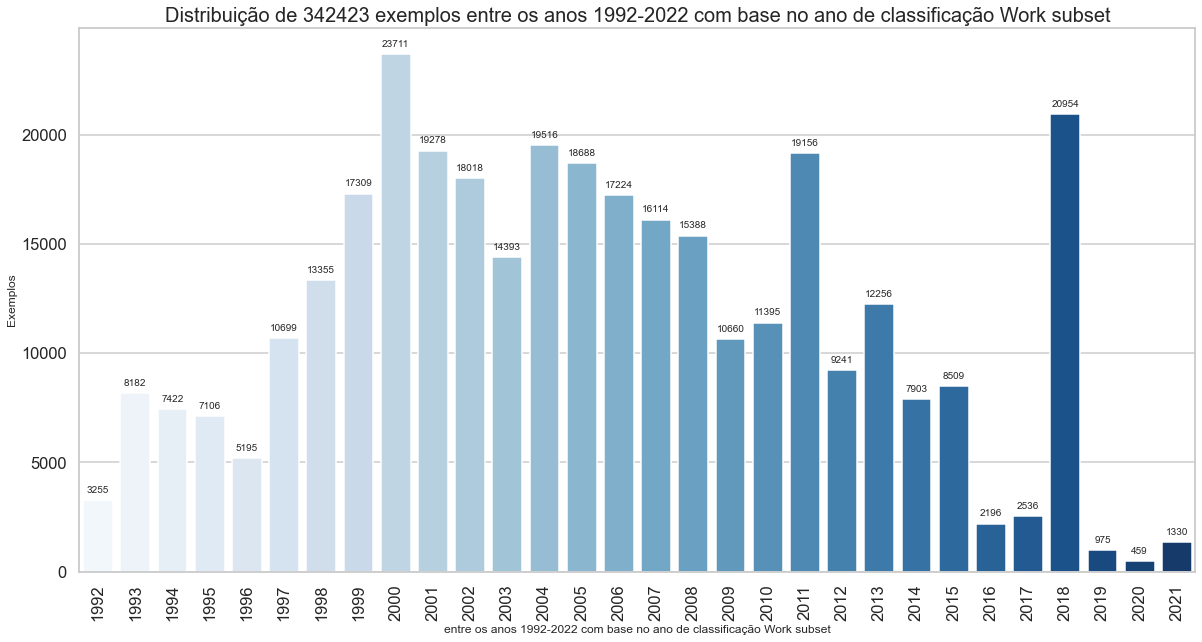

In [11]:
df_plot = df_work.dropna(subset=['classif_date'])

# complete dataset
plot_dist(df_plot['classif_date'].dt.year, label=f'com base no ano de classificação {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['classif_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de classificação {id_label}', palette='Blues');

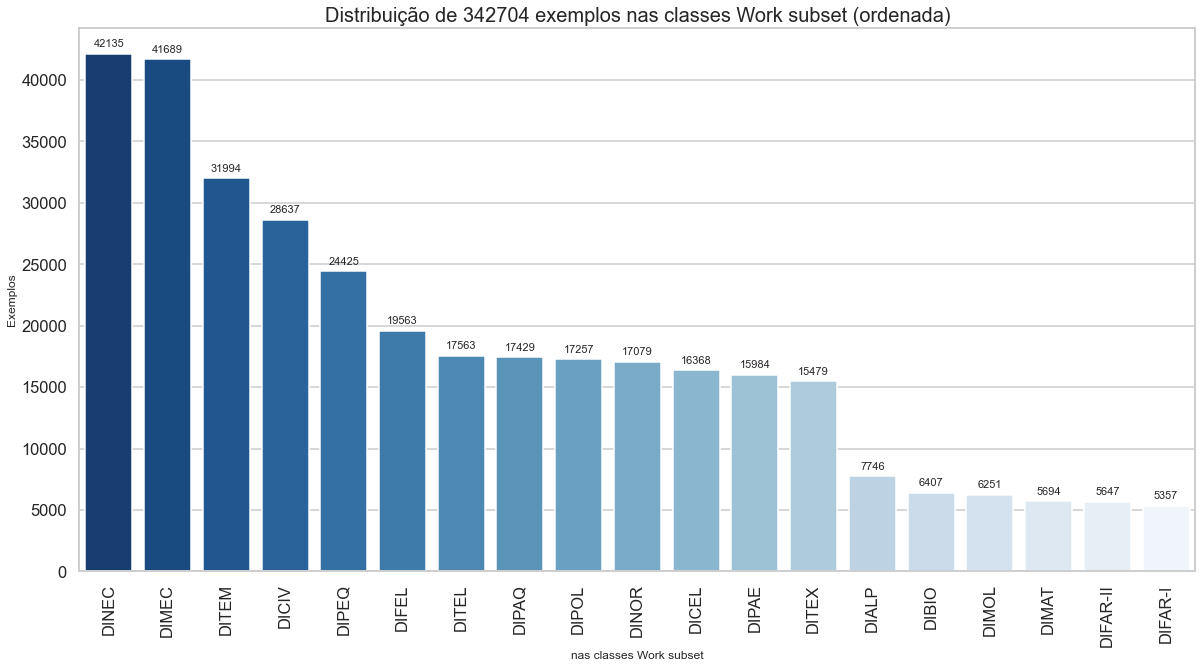

In [13]:
plot_dist(df_work['area'], label=f'nas classes {id_label}', sort=True, data_points_fontsize=11, palette='Blues_r');

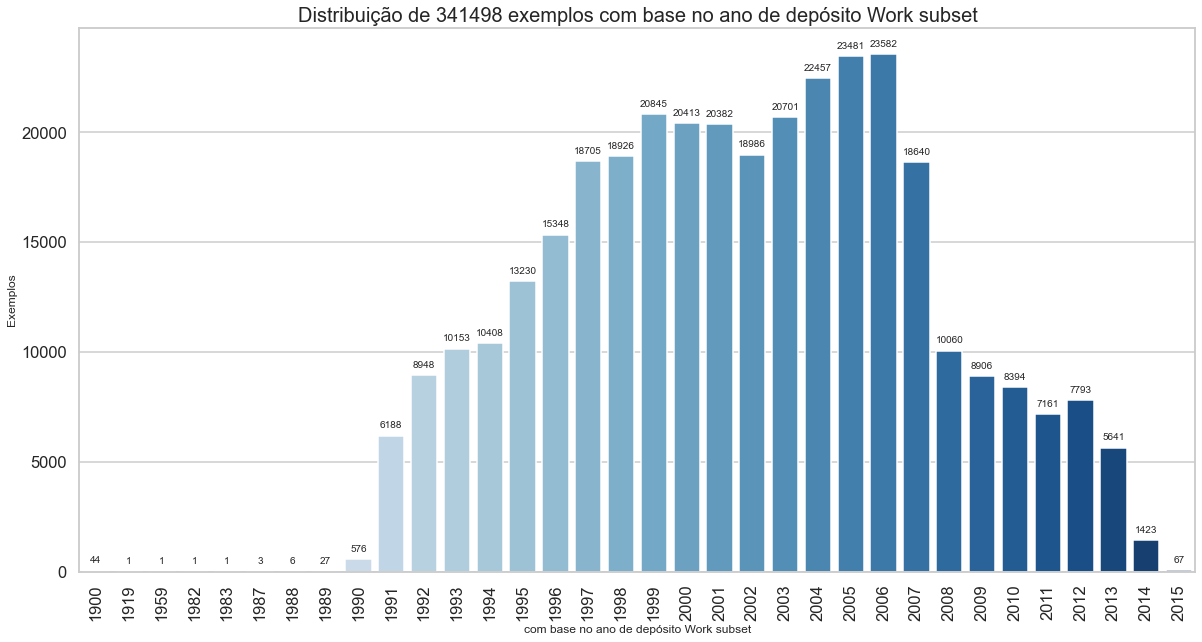

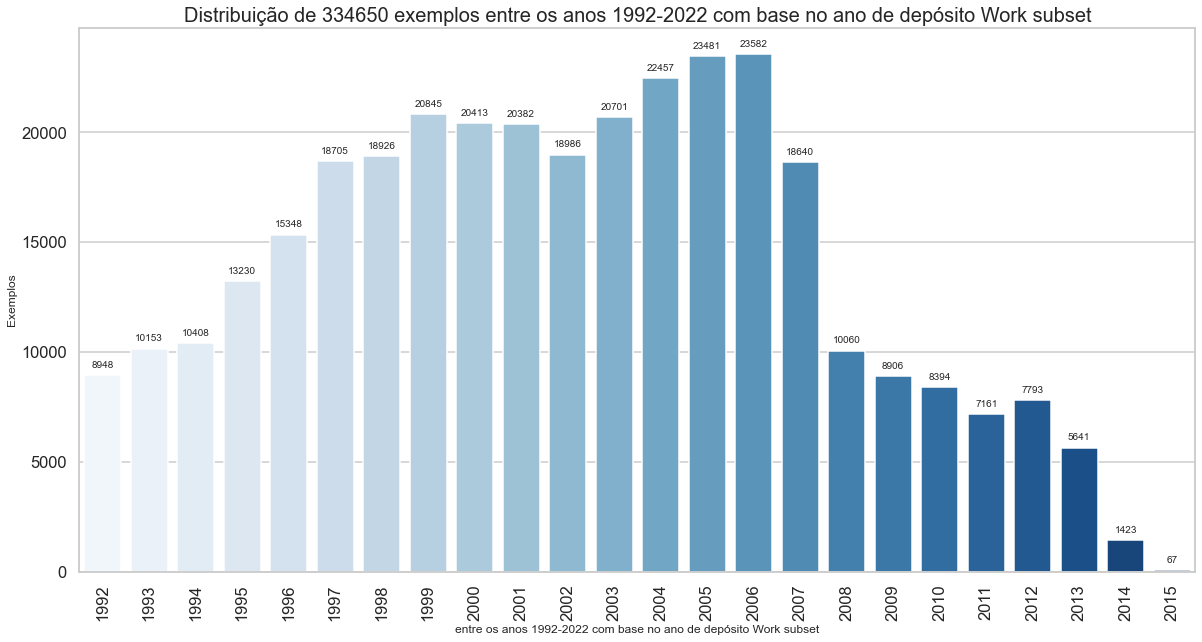

In [14]:
df_plot = df_work.dropna(subset=['deposit_date'])

# complete dataset
plot_dist(df_plot['deposit_date'].dt.year, label=f'com base no ano de depósito {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['deposit_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de depósito {id_label}', palette='Blues');

### Subconjunto de validação (_val)

In [16]:
id_label = 'Val subset'

df_val = load_obj(val_tokens_object)
df_val.sample(5, random_state=RANDOM_STATE)

,no_pedido,classif_date,title,abstract,ipc,titleabstract,area,last_rpi,deposit_date,titleabstract_tokens
19078,BR112015002351,2016-08-02,SISTEMA E MÉTODOS PARA MONITORAR UM FLUIDO E P...,sistema e métodos para monitorar um fluido e p...,"['C12Q 1/04', 'C12Q 1/02']",SISTEMA E MÉTODOS PARA MONITORAR UM FLUIDO E P...,DIALP,2378,NaT,sistem métod monitor flu control qual flu sist...
12336,BR112014032098,2015-03-24,FIBRAS AMBIENTALMENTE RESPONSÁVEIS E ROUPA,resumo fibras ambientalmente responsáveis e ro...,['B28B 17/00'],FIBRAS AMBIENTALMENTE RESPONSÁVEIS E ROUPA res...,DICIV,2307,NaT,fibr ambient respons roup resum fibr ambient r...
31977,BR112019006959,2019-04-16,SISTEMAS E MÉTODOS DE MONITORAMENTO DE PNEU VE...,em uma modalidade um método inclui receber dad...,['B60C 23/04'],SISTEMAS E MÉTODOS DE MONITORAMENTO DE PNEU VE...,DIPEQ,2519,NaT,sistem métod monitor pneu veicul modal métod i...
18018,BR112016004336,2016-03-08,APARELHO INDICADOR DE DEMANDA DE FRENAGEM DE C...,resumo aparelho indicador de demanda de frenag...,"['B60T 7/04', 'B60T 13/66', 'B60T 13/68']",APARELHO INDICADOR DE DEMANDA DE FRENAGEM DE C...,DIMEC,2357,NaT,aparelh indic demand fren condu veícul pes res...
9622,BR112014012846,2014-08-19,MATERIAL CRISTALINO DE ALUMINOSSILICATO O MÉTO...,resumo patente de invenção material cristalino...,"['C01B 39/02', 'C01B 39/46', 'C01B 37/08', 'C0...",MATERIAL CRISTALINO DE ALUMINOSSILICATO O MÉTO...,DINOR,2276,NaT,mater cristalin aluminossilicat métod fabric m...


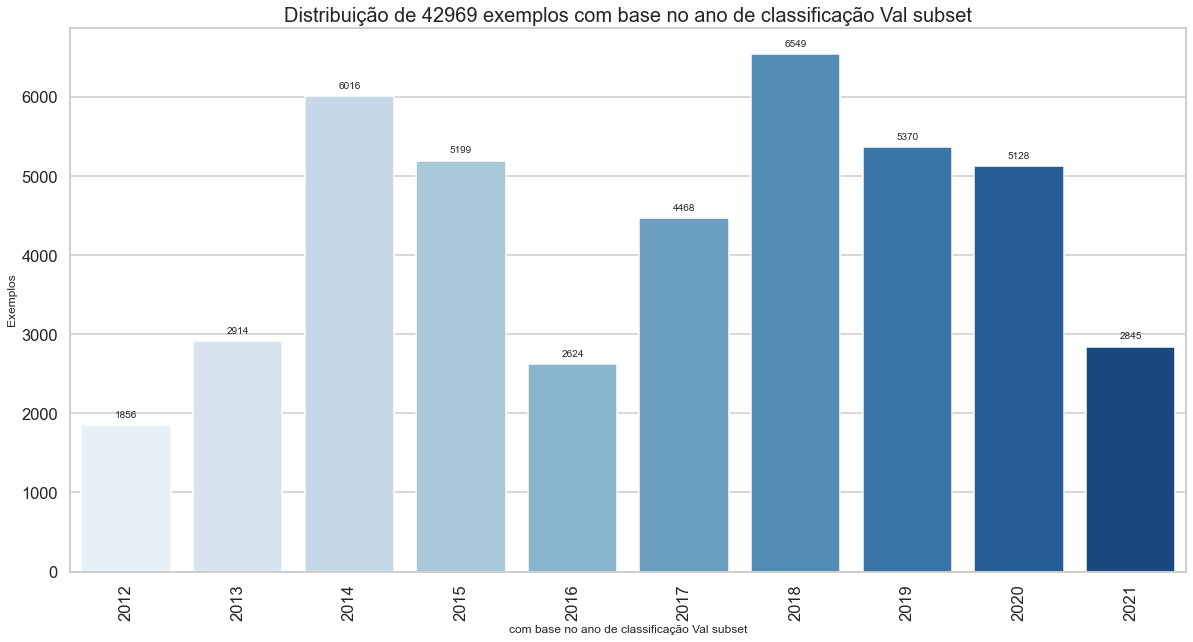

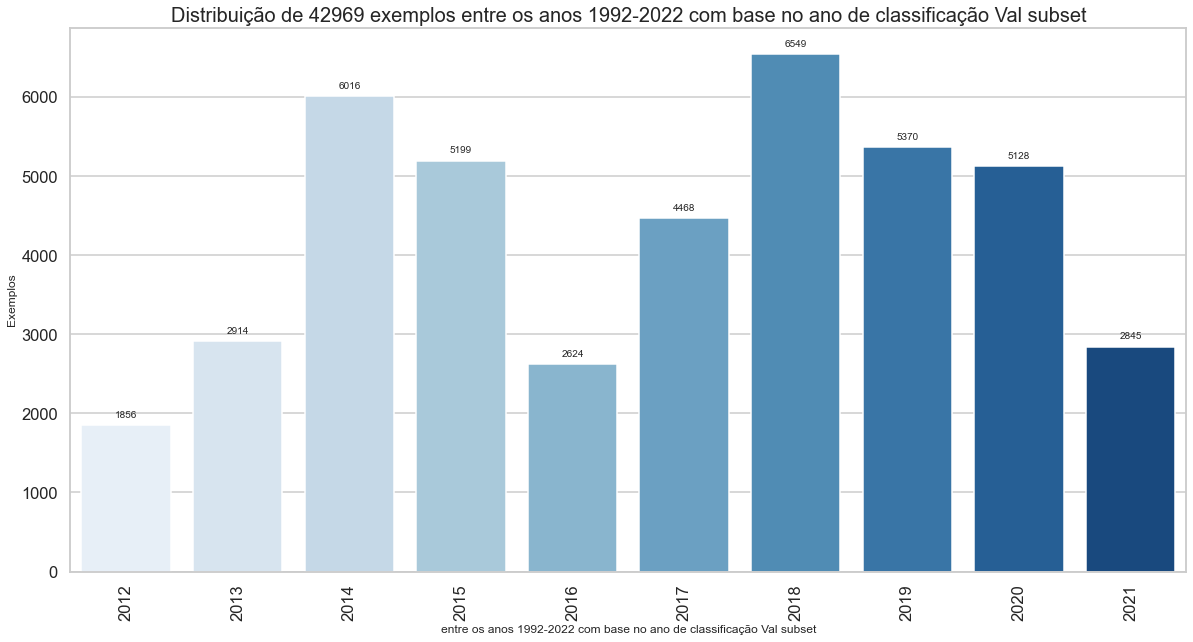

In [17]:
df_plot = df_val.dropna(subset=['classif_date'])

# complete dataset
plot_dist(df_plot['classif_date'].dt.year, label=f'com base no ano de classificação {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['classif_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de classificação {id_label}', palette='Blues');

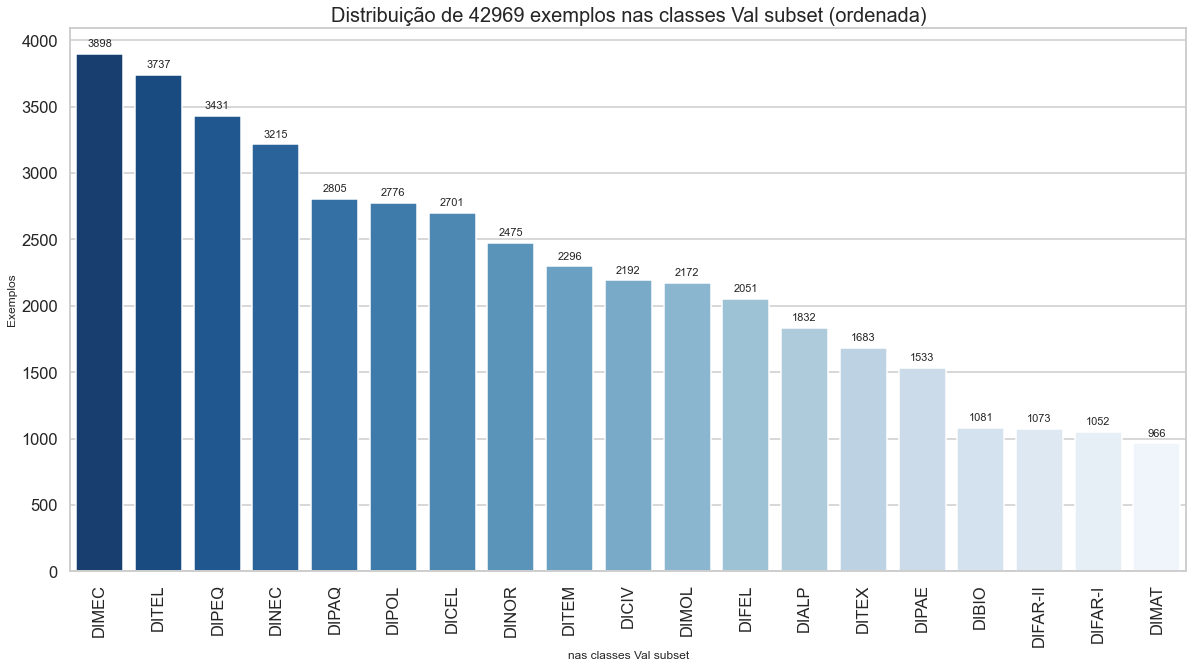

In [18]:
plot_dist(df_val['area'], label=f'nas classes {id_label}', sort=True, data_points_fontsize=11, palette='Blues_r');

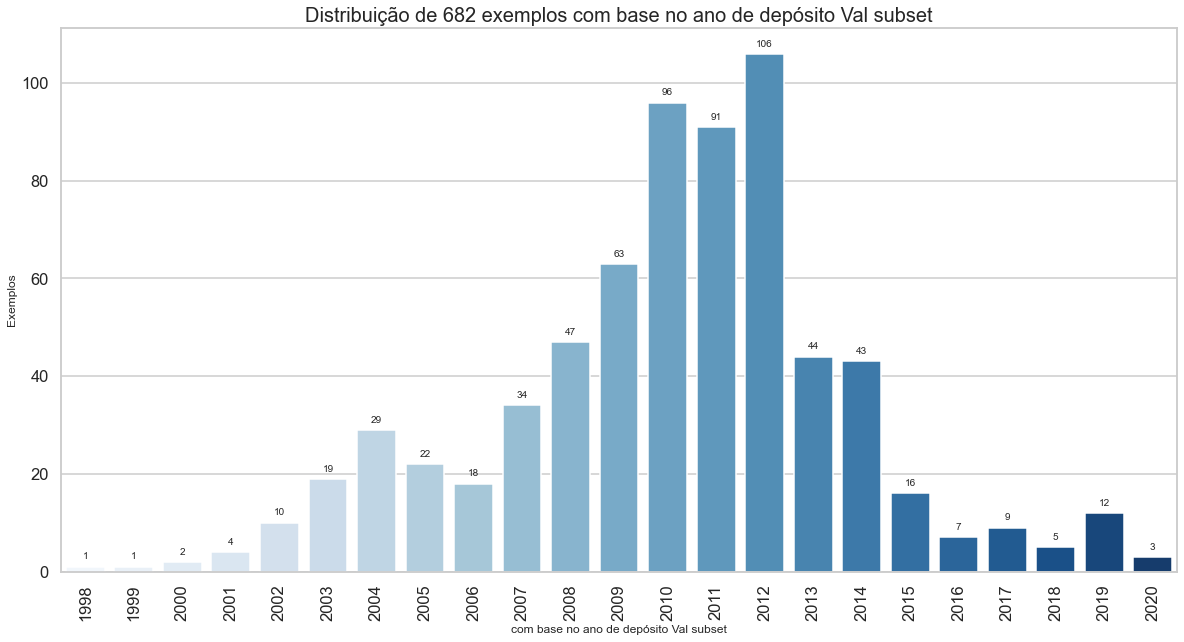

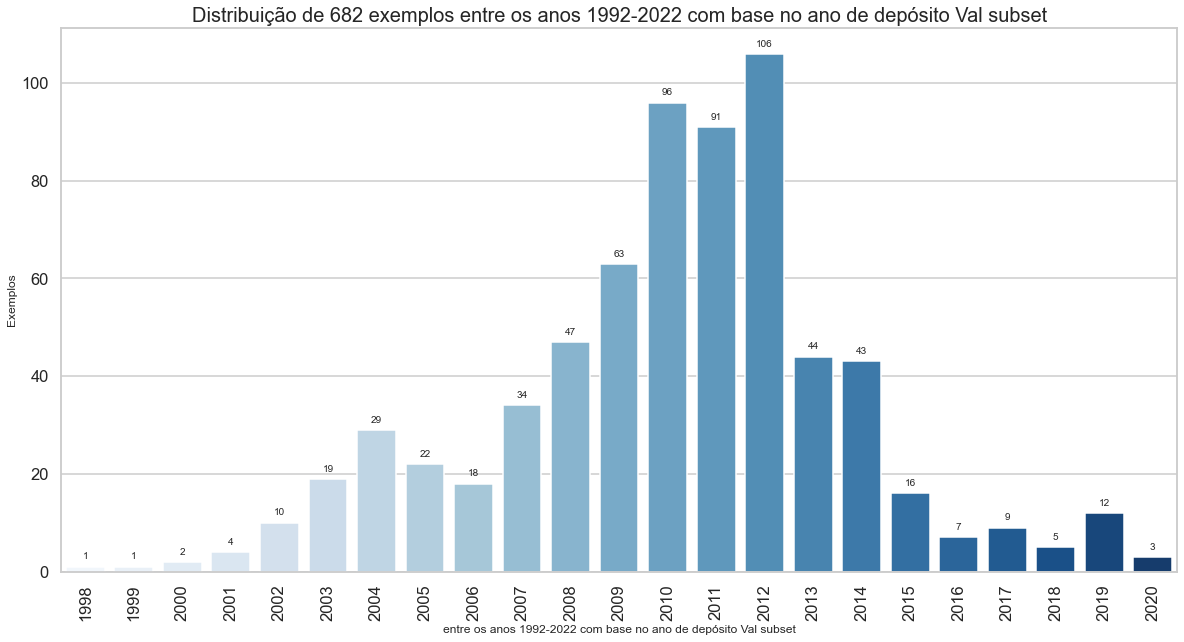

In [19]:
df_plot = df_val.dropna(subset=['deposit_date'])

# complete dataset
plot_dist(df_plot['deposit_date'].dt.year, label=f'com base no ano de depósito {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['deposit_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de depósito {id_label}', palette='Blues');

### Texto utilizado no treinamento

- título + resumo

#### Sobreposição

Repetição completa do título no resumo.

In [20]:
colision_rate = df_work.apply(lambda x: x['title'] in x['abstract'], axis=1).value_counts()[True]/df_work.shape[0]
print(f'Percentual das observações que tem a repetição completa do título no resumo: {colision_rate*100:.2f}%')

Percentual das observações que tem a repetição completa do título no resumo: 61.19%


#### Comprimento do `título + resumo`

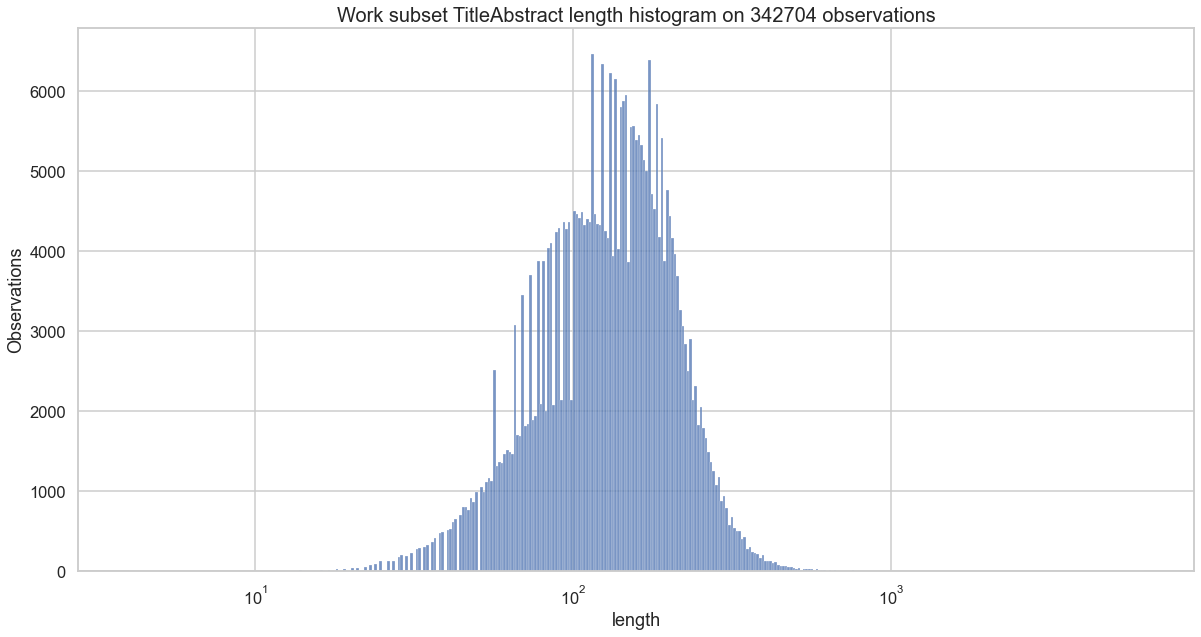

In [21]:
mean, std, median = text_length_hist(df_work['titleabstract'], 'Work subset TitleAbstract')

print(f'TitleAbstract -> Mean length: {mean:.0f} | Std: {std:.0f} | Median: {median:.0f}')
print(f'===>>> suggested max_length: {int(mean + std)}\n')

### Tokens utilizados no treinamento

In [22]:
df_work[['titleabstract', 'titleabstract_tokens', 'area']].sample(5)

,titleabstract,titleabstract_tokens,area
169695,MÉTODO EM TEMPO REAL PARA A MANUTENÇÃO DA ESTA...,métod temp real manutenç estabil form subterrâ...,DICIV
166485,APARELHO PARA INSTALAÇÃO AUTOMÁTICA DE LAÇOS T...,aparelh instal automá laç torc aparelh instal ...,DIPAE
65771,PROCESSO DE DESPOLUIÇÃO ATMOSFÉRICA E DESPOLUI...,process despolu atmosfér despolu gas motor com...,DIMEC
126048,PROCESSO PARA A PREPARAÇÃO DE ÓXIDO DE FERRO E...,process prepar óxid ferr eseu empreg patent in...,DINOR
111040,MEIO ÓPTICO DE GRAVAÇÃO E CARTUCHO PARA DISCO ...,mei óptic grav cartuch disc mei óptic grav car...,DICEL


## Features de validação

Extraídas do subconjunto de validação, a partir do treinamento feito sobre o subconjunto de treinamento.

In [23]:
corpus = df_val['titleabstract_tokens'].values
labels = df_val['area'].values

### TF-IDF (sklearn.feature_extraction.text.TfidfVectorizer)

In [ ]:
tfidf = load_obj(TFIDF)

vocabulary = tfidf.get_feature_names_out()
print(f'O vocabulário aprendido durante o treinamento tem {len(vocabulary)} tokens, derivados das palavras')

X_tfidf = tfidf.transform(corpus)
print(f'----- O TF-IDF calculado para o subconjunto de validação tem:')
print(f'- Valor mínimo para o TF-IDF = {X_tfidf.min()}')
print(f'- Valor máximo para o TF-IDF = {X_tfidf.max()}')
print(f'-------------------------------------------------------------')

print(f'A matrix TF-IDF calculada para o subconjunto de validação tem o seguinte formato: {X_tfidf.shape}')

# Visualizing Feature Matrix
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(X_tfidf.todense()[:, np.random.randint(0, X_tfidf.shape[1], 100)]==0, vmin=0, vmax=1, cbar=False, palette='Blues').set_title('Matriz TF-IDF de validação');


O vocabulário aprendido durante o treinamento tem 193983 tokens, derivados das palavras


### LSA (sklearn.decomposition.TruncatedSVD)

In [22]:
lsa = load_obj(LSA)

X_lsa = lsa.transform(X_tfidf)
print(f'----- O LSA calculado para o subconjunto de validação tem:')
print(f'- Valor mínimo para o LSA = {X_lsa.min()}')
print(f'- Valor máximo para o LSA = {X_lsa.max()}')
print(f'----------------------------------------------------------')
print(f'A matrix LSA calculada para o subconjunto de validação tem o seguinte formato: {X_lsa.shape}')

# Visualizing Feature Matrix
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(X_lsa[:, np.random.randint(0, X_lsa.shape[1], 100)]==0, vmin=0, vmax=1, cbar=False, palette='Blues').set_title('Matriz LSA de validação');

AttributeError: 'NoneType' object has no attribute 'transform'

### Classes

In [23]:
enc = load_obj(ENC)
y = enc.transform(labels)

## Classifier

### Falcon Heavy | SVM - Support Vector Machine

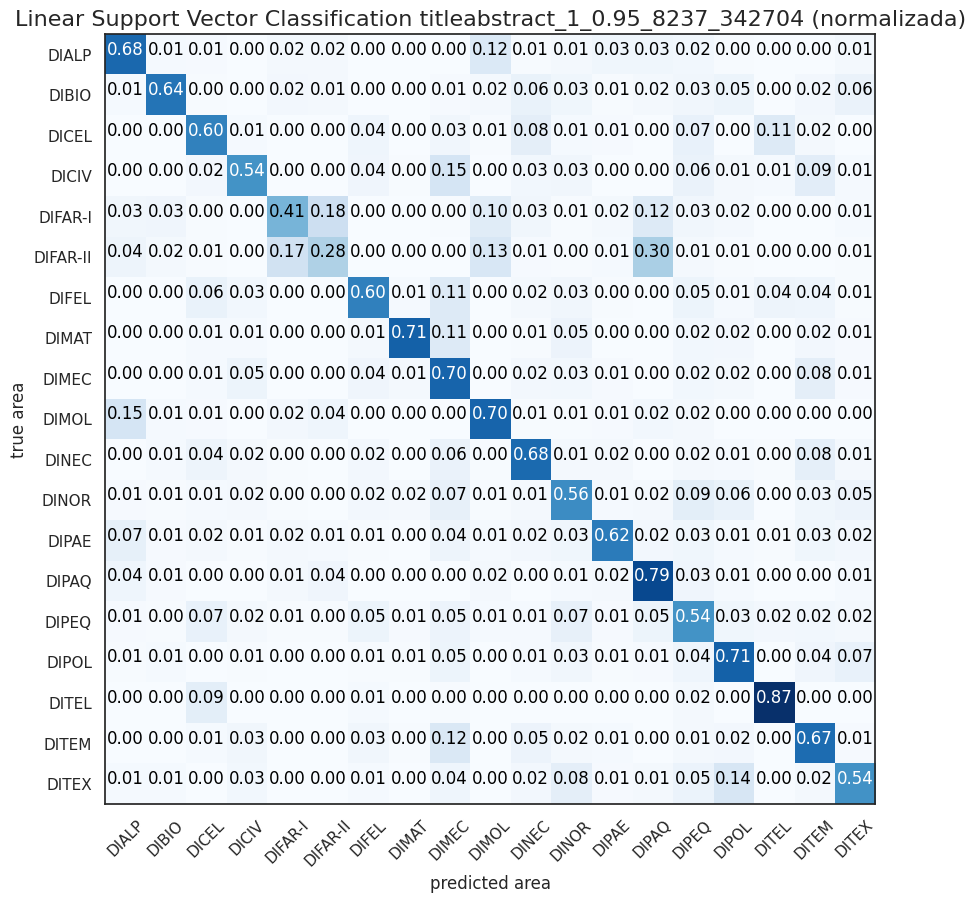

In [55]:
# Classifier
clf = load_obj(SVM)

# Predict Classes
predicted = clf.predict(X_tfidf)
# predicted_prob = estimator.predict_proba(X_tfidf)


# Measure Performance
acc = metrics.accuracy_score(y, predicted)
# auc = metrics.roc_auc_score(y, predicted_prob, multi_class='ovr')
print(f'Accuracy: {round(acc * 100, 2)}%')
# print(f'AUC (Area Under the Curve): {round(auc*100, 2)}%')
print('Details:')
print(metrics.classification_report(y, predicted, zero_division=0))

# Confusion Matrix
filename = os.path.join(ENV['CACHE_FOLDER'], SVM_cm)
cm_img = Image(filename, width=950, unconfined=True)
display(cm_img)

### Falcon 9 | MLP - Multi-layer Perceptron

In [ ]:
# Fit Classifier
estimator = load_obj(MLP)
# model = pipeline.Pipeline([('vectorizer', tfidf), ('reduction', lsa), ('estimator', estimator)])
# model['estimator'].fit(X_train.toarray(), train_labels) #  estou lendo o clf já treinado!


# Predict Classes
predicted = estimator.predict(X_lsa)
predicted_prob = estimator.predict_proba(X_lsa)


# Measure Performance
acc = metrics.accuracy_score(y, predicted)
auc = metrics.roc_auc_score(y, predicted_prob, multi_class='ovr')
print(f'Accuracy: {round(acc*100, 2)}%')
print(f'AUC (Area Under the Curve): {round(auc*100, 2)}%')
print('Details:')
print(metrics.classification_report(y, predicted, zero_division=0))


In [ ]:
classes = enc.classes_
# Plot Confusion Matrix
cm = metrics.confusion_matrix(y, predicted)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=True);
ax.set(xlabel='Predicted', 
       ylabel='True', 
       xticklabels=classes, 
       yticklabels=classes, 
       title='');
plt.title(f'Confusion Matrix | {obj_cache_name} | y_{y.shape[0]}', fontsize=20)
plt.yticks(rotation=0);
plt.xticks(rotation=45);


y_array = pd.get_dummies(labels, drop_first=False).values
# ROC curve per class
fig, ax = plt.subplots(figsize=(20,10));
for i in range(len(classes)):
    fpr, tpr, threshold = metrics.roc_curve(y_array[:, i], predicted_prob[:, i]);
    ax.plot(fpr, tpr, lw=2, label=f'{classes[i]} (area={metrics.auc(fpr, tpr):0.2f})');
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
ax.set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05], 
       xlabel='False Positive Rate', 
       ylabel='True Positive Rate (Recall)');
plt.title(f'Receiver Operating Characteristic | {obj_cache_name} | y_{y.shape[0]}', fontsize=20)
ax.legend(loc='lower right');
ax.grid(True);

filename = f'roc_curve_{obj_cache_name}_y_{y.shape[0]}.png'
fig.savefig(os.path.join(ENV['CACHE_FOLDER'], filename), bbox_inches='tight');

## Results

In [7]:
# Importing Development Experiments folds results and creating summary
results = pd.DataFrame()
for filename in os.listdir(ENV['CACHE_FOLDER']):
#     query = '(^results_cycle2_.*_(073158|225657|074314|064547))\.joblib\.z$'
    query = r'(^results_cycle2_.*)\.joblib\.z$'
    match = re.search(query, filename)
    if match:
        filename = match.group(1)
        _, *experiment_name, date, time = filename.split('_')
        experiment_id = '_'.join(experiment_name)
        
        df_ = pd.DataFrame(load_obj(filename))
        results = pd.concat([results, df_])
        
        print(f'Imported {_} from experiment: {experiment_id}, ran: {date}|{time}')

results.insert(2, "feature_type", 
               results.apply(lambda row: 'tfidf' if row['X_n_dims'] == 0 else f'lsa_{row["X_n_dims"]}',
                             axis=1))
results = results.astype({
    'train_observations': 'int32',
    'random_seed': 'int32',
    'max_df': 'float',
    'n_grams': 'int32',
    'X_n_dims': 'int32',
    'hyperparams': 'str'
})
summary = results.drop_duplicates(subset=['X_column', 'train_observations', 'estimator',
                                          'feature_type', 'max_df'])
# Report
print(2 * '\n')
print(f'Results shape: {results.shape} ==> all data')
print(f'Summary shape: {summary.shape} ==> only unique validated_mean_Accuracy')
print(2 * '\n')
results.columns
print(2 * '\n')


# Persist
results.to_csv('evaluation_folds_results.csv', sep='|', index=False)
summary.to_csv('evaluation_folds_summary.csv', sep='|', index=False)

Imported results from experiment: cycle2_estimators, ran: 20220605|073158
Imported results from experiment: cycle2_features, ran: 20220527|225657
Imported results from experiment: cycle2_falcon-heavy, ran: 20220608|074314
Imported results from experiment: cycle2_falcon-nine, ran: 20220610|064547
Imported results from experiment: cycle2_evaluation, ran: 20220805|014342
Imported results from experiment: cycle2_evaluation, ran: 20220812|092714



Results shape: (2253, 29) ==> all data
Summary shape: (134, 29) ==> only unique validated_mean_Accuracy





Index(['estimator', 'X_n_dims', 'feature_type', 'X_column', 'n_grams',
       'max_df', 'random_seed', 'train_observations', 'hyperparams',
       'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'best_mean_Accuracy', 'validated_mean_Accuracy',
       'validated_confusion_matrix', 'validated_f1score_weighted',
       'test_Accuracy', 'mean_Accuracy', 'std_Accuracy', 'test_F1score',
       'mean_F1score', 'std_F1score', 'test_Precision', 'mean_Precision',
       'std_Precision', 'test_Recall', 'mean_Recall', 'std_Recall'],
      dtype='object')

## Melhores resultado por tipo de feature, algoritmo e número de exemplos

In [11]:
overall_ranking = summary.groupby([
    'estimator', 'feature_type', 'train_observations'
]).agg({
    'mean_Accuracy': 'max',
    'validated_mean_Accuracy': 'max',
    'mean_F1score': 'max',
    'validated_f1score_weighted': 'max'
    }).round(4)*100
general_view = overall_ranking.sort_values(by='validated_mean_Accuracy', ascending=False)
general_view[:10]

mean_Accuracy  \
estimator feature_type train_observations                  
svm       tfidf        308061                      65.82   
                       342704                      66.02   
          lsa_1000     342704                      60.76   
          tfidf        20000                       56.55   
mlp       lsa_1000     308061                      54.37   
                       342704                      56.14   
svm       tfidf        15000                       55.62   
mlp       lsa_1000     20000                       47.59   
svm       lsa_1000     20000                       54.60   
mlp       tfidf        342704                      59.58   

                                           validated_mean_Accuracy  \
estimator feature_type train_observations                            
svm       tfidf        308061                                65.41   
                       342704                                62.32   
          lsa_1000     342704                                59.46   
          tfidf        20000                                 57.88   
mlp       lsa_1000     308061                                56.66   
                       342704                                56.28   
svm       tfidf        15000                                 56.12   
mlp       lsa_1000     20000                                 55.64   
svm       lsa_1000     20000                                 55.62   
mlp       tfidf        342704                                55.08   

                                           mean_F1score  \
estimator feature_type train_observations                 
svm       tfidf        308061                     68.02   
                       342704                     68.27   
          lsa_1000     342704                     63.12   
          tfidf        20000                      59.45   
mlp       lsa_1000     308061                     55.85   
                       342704                     57.59   
svm       tfidf        15000                      58.47   
mlp       lsa_1000     20000                      49.74   
svm       lsa_1000     20000                      57.53   
mlp       tfidf        342704                     62.15   

                                           validated_f1score_weighted  
estimator feature_type train_observations                              
svm       tfidf        308061                                   67.79  
                       342704                                   64.71  
          lsa_1000     342704                                   61.72  
          tfidf        20000                                    60.70  
mlp       lsa_1000     308061                                   58.10  
                       342704                                   58.16  
svm       tfidf        15000                                    59.07  
mlp       lsa_1000     20000                                    58.11  
svm       lsa_1000     20000                                    58.45  
mlp       tfidf        342704                                   57.15

### Tempos

#### Treinamento

In [12]:
# SVM
def get_fit_time(clf, name):
    mean_fit_time = clf.cv_results_['mean_fit_time']
    mean_score_time= clf.cv_results_['mean_score_time']
    n_splits  = clf.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(clf.cv_results_).shape[0] #Iterations per split
    fit_time = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter
    if fit_time > 3600:
        print(f'Tempo médio de treinamento do {name}: {fit_time / 60 / 60:.2f} horas')
    else:
        print(f'Tempo médio de treinamento do {name}: {fit_time / 60:.2f} minutos')

svm = load_obj(FALCON_HEAVY)
get_fit_time(svm, 'Falcon Heavy')

mlp = load_obj(FALCON_NINE)
get_fit_time(mlp, 'Falcon 9')

Tempo médio de treinamento do Falcon Heavy: 4.47 minutos
Tempo médio de treinamento do Falcon 9: 97.28 horas


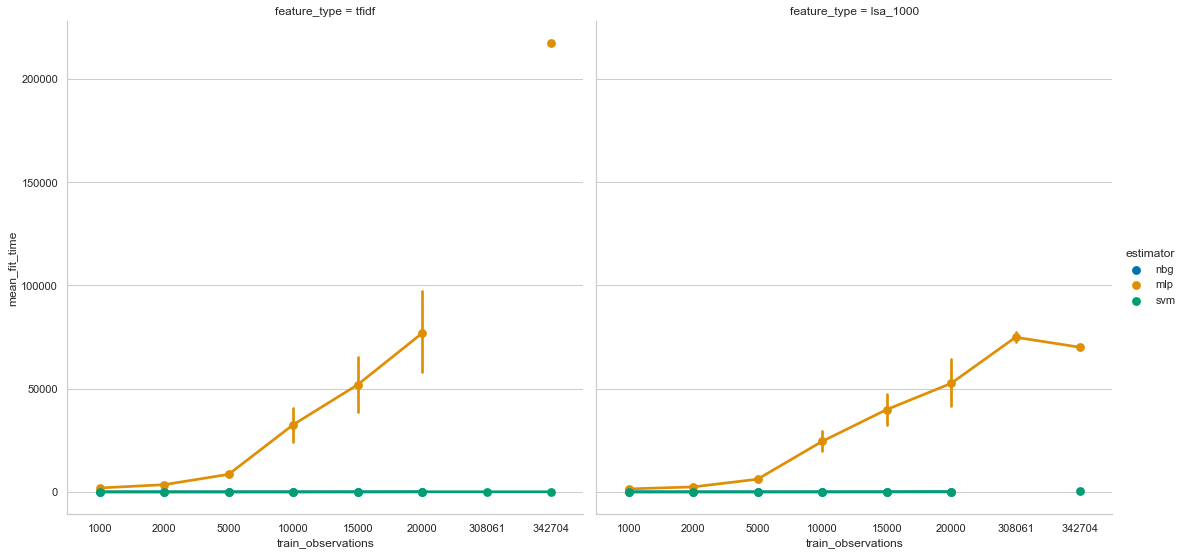

In [13]:
y = 'mean_fit_time'
x = 'train_observations'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

#### Previsão

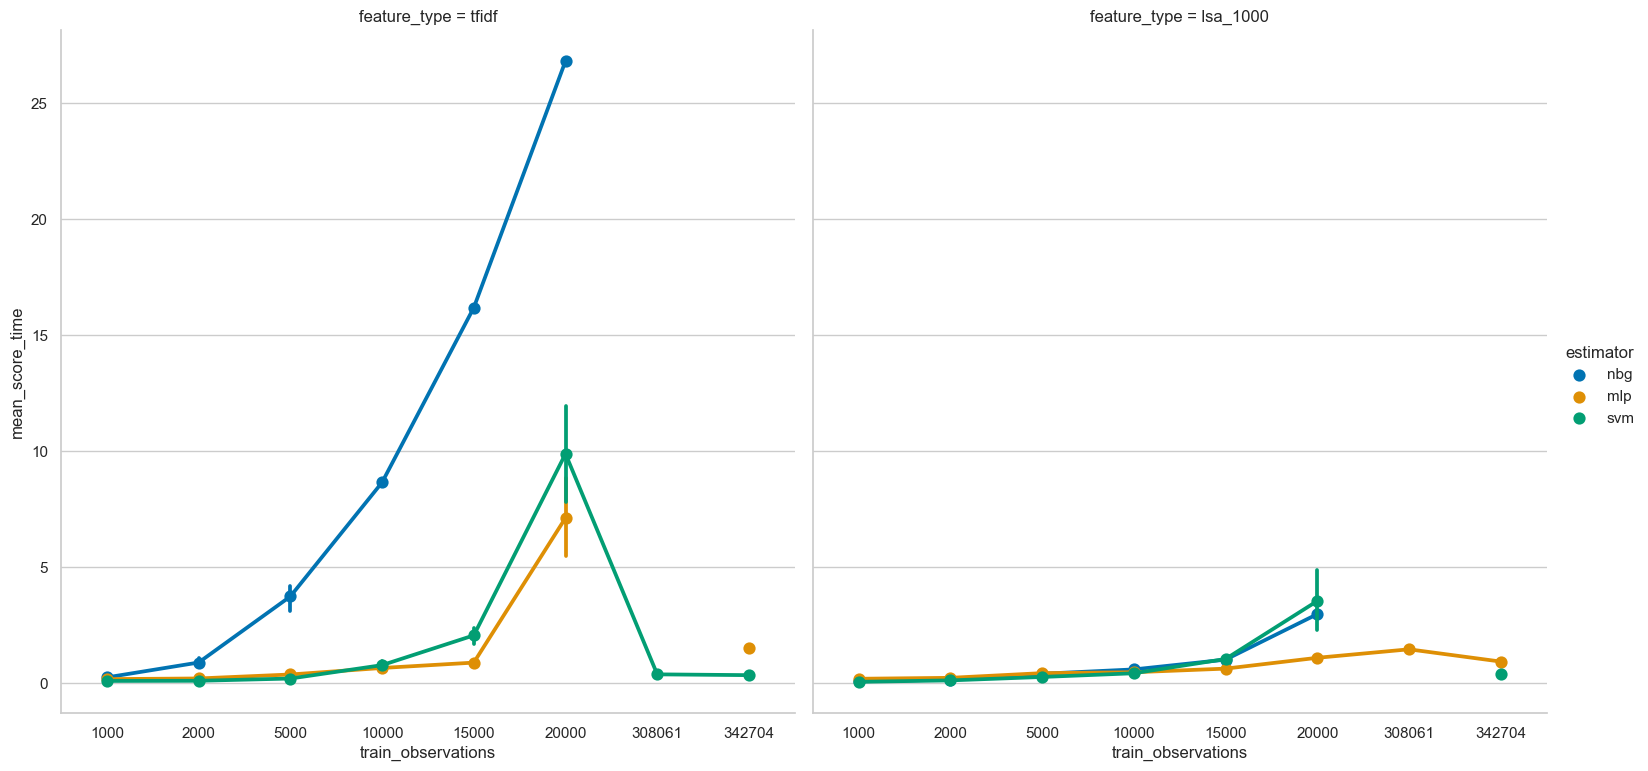

In [14]:
y = 'mean_score_time'
x = 'train_observations'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

### Desempenho

#### test_Accuracy

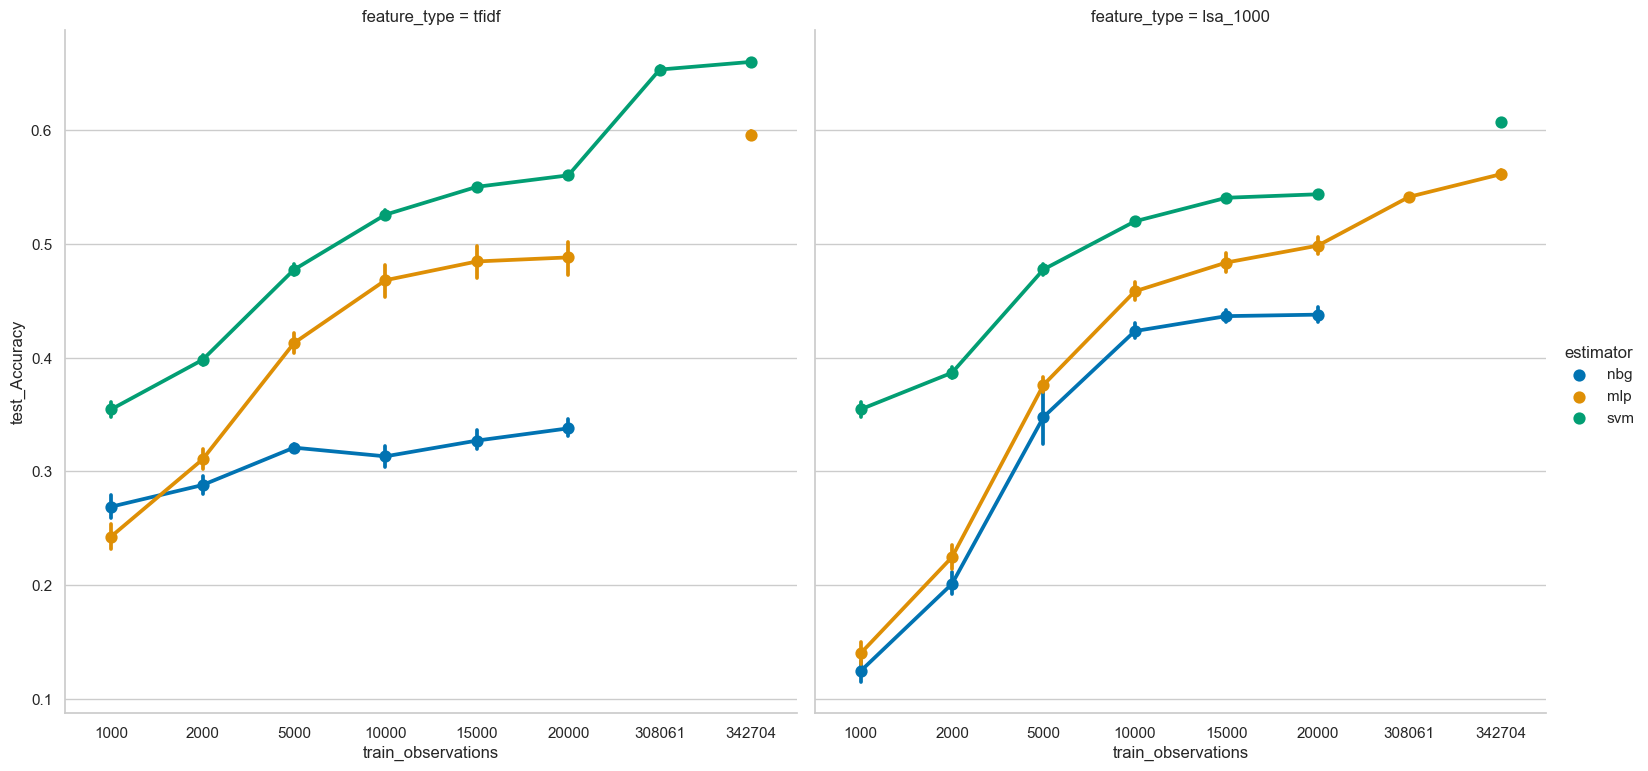

In [15]:
y = 'test_Accuracy'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

#### validated_mean_Accuracy

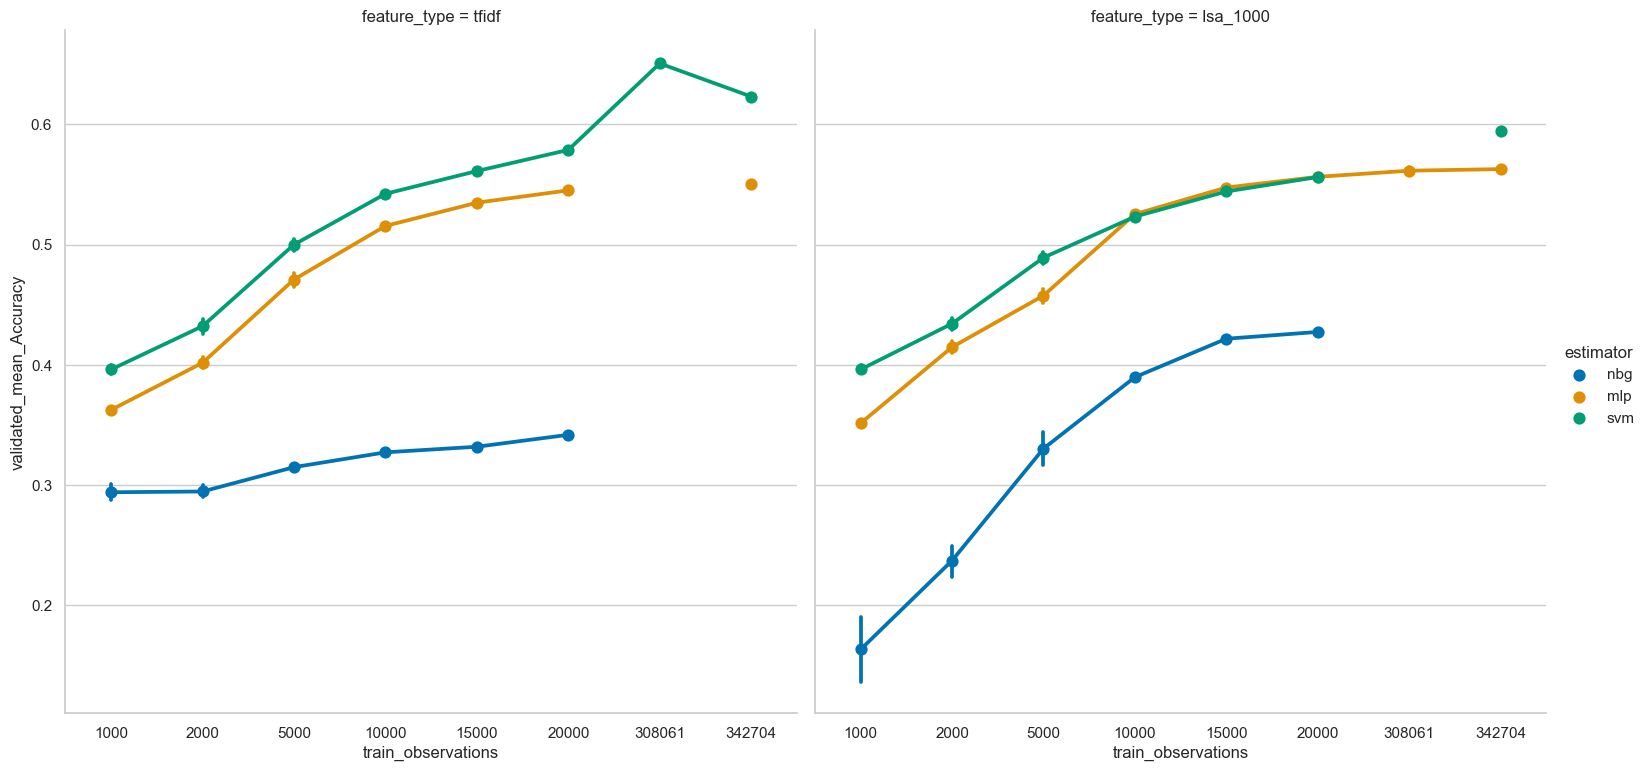

In [16]:
y = 'validated_mean_Accuracy'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

### Valores test_ por estimador

In [17]:
select_nbg = results[results['estimator'] == 'nbg']
print(f'Todos os valores test_ para NBG: {select_nbg.shape}')

select_mlp = results[results['estimator'] == 'mlp']
print(f'Todos os valores test_ para NBG: {select_mlp.shape}')

select_svm = results[results['estimator'] == 'svm']
print(f'Todos os valores test_ para NBG: {select_svm.shape}')

select_nbg.shape[0] + select_mlp.shape[0] + select_svm.shape[0]

Todos os valores test_ para NBG: (138, 29)
Todos os valores test_ para NBG: (1262, 29)
Todos os valores test_ para NBG: (853, 29)


2253